# Análise da base de dados por meio do algoritmo k-Nearest Neighbors (kNN)

## Bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Carregando a base de dados numa planilha do Google Sheets

In [11]:
url = r"https://docs.google.com/spreadsheets/d/e/2PACX-1vTSEtC2uCzOX9-5zgkIkuqyZA51Z5nGlem0Y5w6kbLPcmzENBe0yujL9WAGBDgT9y7VBQniOlMg4Baf/pub?output=csv"

insta_df = pd.read_csv(url)

insta_df.head()

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
3,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
4,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States


# Conhecendo a base

In [12]:
insta_df.describe()

,rank,influence_score
count,200.000000,200.000000
mean,100.500000,81.820000
std,57.879185,8.878159
min,1.000000,22.000000
25%,50.750000,80.000000
50%,100.500000,84.000000
75%,150.250000,86.000000
max,200.000000,93.000000


In [13]:
insta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rank               200 non-null    int64 
 1   channel_info       200 non-null    object
 2   influence_score    200 non-null    int64 
 3   posts              200 non-null    object
 4   followers          200 non-null    object
 5   avg_likes          200 non-null    object
 6   60_day_eng_rate    200 non-null    object
 7   new_post_avg_like  200 non-null    object
 8   total_likes        200 non-null    object
 9   country            138 non-null    object
dtypes: int64(2), object(8)
memory usage: 15.8+ KB


In [14]:
insta_df['country'].value_counts()

country
United States             66
Brazil                    13
India                     12
Indonesia                  7
France                     6
Spain                      5
United Kingdom             4
Colombia                   3
Canada                     3
Mexico                     2
Turkey                     2
Netherlands                2
Switzerland                1
Germany                    1
Czech Republic             1
British Virgin Islands     1
Sweden                     1
Australia                  1
Anguilla                   1
CÃ´te d'Ivoire             1
Puerto Rico                1
United Arab Emirates       1
Italy                      1
Uruguay                    1
Russia                     1
Name: count, dtype: int64

# Tratando os dados

## Convertendo os sufixos das colunas que seriam numéricas

In [ ]:
# Função para converter valores com sufixos 'b', 'm' e 'k' para int
def converter_sufixo(valor):
    if isinstance(valor, str):
        if 'b' in valor:
            return int(float(valor.replace('b', '')) * 1e9)
        elif 'm' in valor:
            return int(float(valor.replace('m', '')) * 1e6)
        elif 'k' in valor:
            return int(float(valor.replace('k', '')) * 1e3)
    return valor

colunas_num = ['posts', 'followers', 'avg_likes', 'new_post_avg_like', 'total_likes']

# Aplicar a função nas colunas
for col in colunas_num:
    insta_df[col] = insta_df[col].apply(converter_sufixo)

# Transformar em int64
for col in colunas_num:
    insta_df[col] = insta_df[col].astype(np.int64)

insta_df.head(3)

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3300,475800000,8700000,1.39%,6500000,29000000000,Spain
1,2,kyliejenner,91,6900,366200000,8300000,1.62%,5900000,57400000000,United States
2,3,leomessi,90,890,357300000,6800000,1.24%,4400000,6000000000,NaN


## Retirando o '%' da coluna 60_day_eng_rate

In [16]:
# Função para remover '%' e dividir por 100
def converter_percentual(valor):
    if isinstance(valor, str) and '%' in valor:
        return float(valor.replace('%', '')) / 100
    return valor

insta_df['60_day_eng_rate'] = insta_df['60_day_eng_rate'].apply(converter_percentual)
insta_df['60_day_eng_rate'] = insta_df['60_day_eng_rate'].astype(np.float64)

insta_df.head(3)

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3300,475800000,8700000,0.0139,6500000,29000000000,Spain
1,2,kyliejenner,91,6900,366200000,8300000,0.0162,5900000,57400000000,United States
2,3,leomessi,90,890,357300000,6800000,0.0124,4400000,6000000000,NaN


## Mapear os continentes para cada país

In [18]:
mapa_continentes = {'Brazil': 1, 
                    'Uruguay': 2,  
                    'Colombia': 3,
                    'British Virgin Islands': 10,
                    'Puerto Rico': 11,
                    'Anguilla': 12,
                    'Mexico': 20, 
                    'United States': 21,
                    'Canada': 22,  
                    'Germany': 40, 
                    'France': 41, 
                    'United Kingdom': 42,
                    'Russia': 43,
                    'Italy': 44, 
                    'Sweden': 45,
                    'Netherlands': 46,
                    'Czech Republic': 47,
                    'Switzerland': 48,
                    'Spain': 49,
                    'Turkey': 50,  
                    'India': 60, 
                    'United Arab Emirates': 61,
                    "CÃ´te d'Ivoire": 70,
                    'Indonesia': 80,
                    'Australia': 100}

# Função para mapear países a continentes
def mapear_continente(pais):
    return mapa_continentes.get(pais, None)

# Aplicar a função na coluna 'country'
insta_df['continent_code'] = insta_df['country'].apply(mapear_continente)

insta_df.tail()


,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country,continent_code
195,196,iambeckyg,71,2300,33200000,623800,0.0140,464700,1400000000,United States,21.0
196,197,nancyajram,81,3800,33200000,390400,0.0064,208000,1500000000,France,41.0
197,198,luansantana,79,770,33200000,193300,0.0026,82600,149200000,Brazil,1.0
198,199,nickjonas,78,2300,33000000,719600,0.0142,467700,1700000000,United States,21.0
199,200,raisa6690,80,4200,32799999,232200,0.0030,97400,969100000,Indonesia,80.0


# Análise exploratória

## Correlações entre variáveis

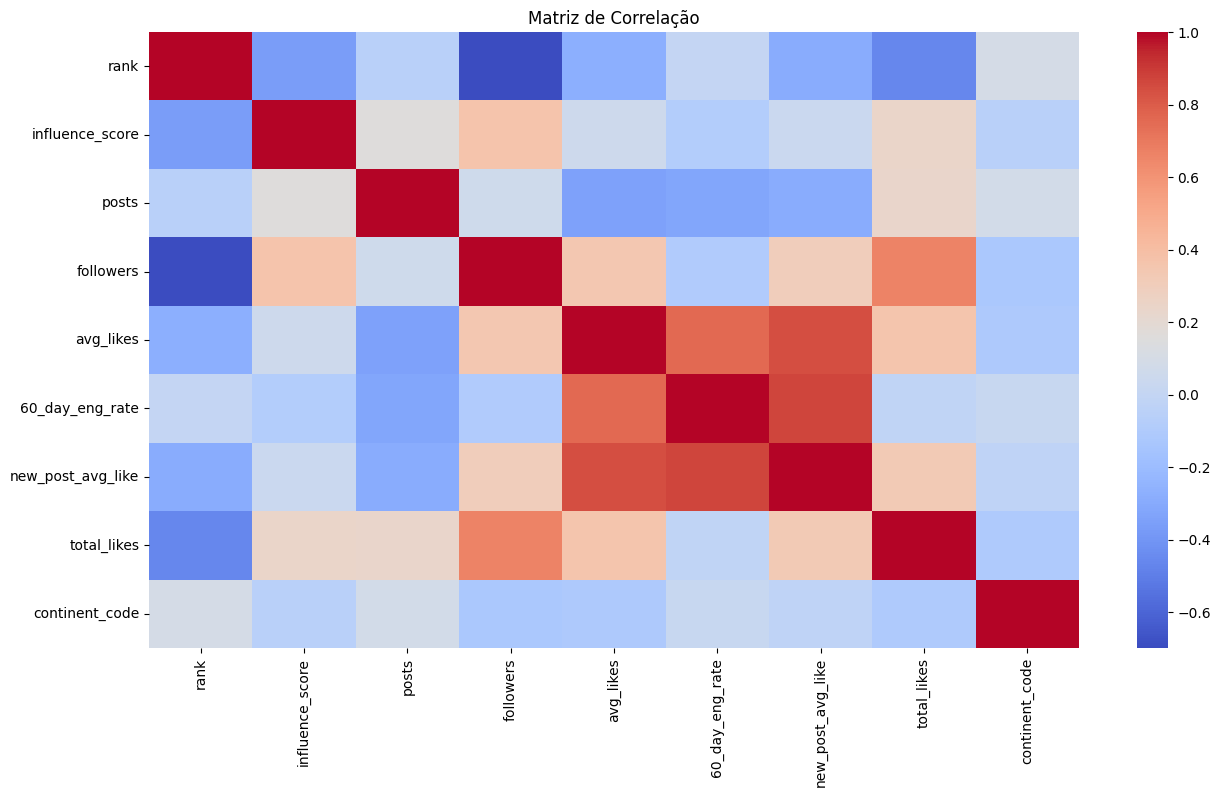

In [19]:
corr = insta_df.corr(numeric_only=True)

plt.figure(figsize=(15, 8))
sns.heatmap(corr, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

### Relação entre followers e avg_likes

As colunas tem correlação positiva fraca, o que é contraintuitivo, visto que a ideia é que quanto maior a quantidade de seguidores, a média de likes cresceria na mesma proporção. Isso pode sugerir que apenas uma parcela dos novos seguidores realmente curtem os posts do influencer.

### Impacto de 60_day_eng_rate na taxa de engajamento (influence_score)

A taxa de engajamento dos últimos 60 dias apresenta correlação nula com a taxa de engajamento do influencer.
Isso pode ser explicado talvez pelo fato de que pessoas muito famosas não perdem o engajamento mesmo estando dias sem fazer um post. Essas pessoas recebem muitas curtidas independente do intervalo de tempo entre os posts.